In [ ]:
# Run this then restart runtime to get updated packages
!pip install --upgrade scikit-learn numpy pandas shap xgboost lightgbm imbalanced-learn matplotlib seaborn scipy umap-learn datashader bokeh holoviews scikit-image colorcet tqdm

     |████████████████████████████████| 23.2 MB 1.1 MB/s 
     |████████████████████████████████| 15.7 MB 59.7 MB/s 
     |████████████████████████████████| 11.3 MB 65.6 MB/s 
     |████████████████████████████████| 371 kB 86.9 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 173.5 MB 30 kB/s 
     |████████████████████████████████| 2.0 MB 75.9 MB/s 
     |████████████████████████████████| 189 kB 77.5 MB/s 
     |████████████████████████████████| 10.3 MB 67.2 MB/s 
     |████████████████████████████████| 38.2 MB 44 kB/s 
     |████████████████████████████████| 86 kB 7.6 MB/s 
     |████████████████████████████████| 15.8 MB 77.4 MB/s 
     |████████████████████████████████| 18.5 MB 93 kB/s 
     |████████████████████████████████| 29.2 MB 1.2 MB/s 
     |████████████████████████████████| 1.1 MB 58.8 MB/s 
     |████████████████████████████████| 76 kB 6.6 MB/s 
     |

In [ ]:
#Grab shap for model interpretation/feature importance
!pip install shap

In [ ]:
# Mount google drive to import our feature engineered data
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Tools
import pandas as pd, numpy as np, time as time, gc as gc
gc.enable()

# Visualization / Clustering
from sklearn.decomposition import PCA
import umap

# Visualizations
import matplotlib.pyplot as plt, seaborn as sns, plotly.express as px
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

# Feature Importance
import shap
shap.initjs()

# Model Scoring
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score, mean_squared_error

# Other
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, Normalizer, QuantileTransformer, minmax_scale
from sklearn.model_selection import train_test_split

# Models
from sklearn.linear_model import ElasticNetCV
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import VotingRegressor

In [ ]:
# Download Data
base_dir = '/content/gdrive/MyDrive/Colab Notebooks/ncaa_competition/MDataFiles_Stage1_Spread/'
df = pd.read_csv(base_dir+'full_data_all_games.csv')

In [ ]:
# One hot encode the object (categorical) data
def one_hot_encode(df, features):
  for feature in features:
    dummies = pd.get_dummies(df[feature])
    df = pd.concat([df, dummies], axis=1)
    df.drop(feature, inplace=True, axis=1)
  
  return df

# Show the difference in dimensions after encoding
print(df.shape)
encoded_df = one_hot_encode(df, [x for x in df.columns if str(df[x].dtype) == 'object'])
print(encoded_df.shape)

(115949, 58)
(115949, 94)


In [ ]:
# Remove potential duplicate features 
print(encoded_df.shape)
encoded_df = encoded_df.loc[:,~encoded_df.columns.duplicated()]
print(encoded_df.shape)

# and NaNs. Due to the rolling basketball stats, the first 5 games of for every team will be dropped. 
# There may be a better workaround for this data loss, but this is the simple solution for now.

encoded_df = encoded_df.dropna()
print(encoded_df.shape)

(115949, 94)
(115949, 94)
(99322, 94)


In [ ]:
# Create training and testing sets. 
# Trying to predict recent seasons with past seasons instead of your regular 70/30 train test split.

train = encoded_df.loc[(encoded_df['Season'] < 2019) & (encoded_df['Season'] >= 2003)]
train_label = train['Score']
train.drop('Score', inplace=True, axis=1)

test = encoded_df.loc[(encoded_df['Season'] == 2019) | (encoded_df['Season'] == 2020)]
test_label = test['Score']
test.drop('Score', inplace=True, axis=1)

train.drop(['Unnamed: 0', 'index'], inplace=True, axis=1)
test.drop(['Unnamed: 0', 'index'], inplace=True, axis=1)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
# Utilize five total models, including three individuals, to forecast results

"""
NOTE - The model parameters were selected via an offline gridsearch we did that is not included in this repository
"""

# Elasticnet
elasticnet_params = {'verbose': 1, 'random_state': 8, 'fit_intercept': True, 
                     'l1_ratio': 0.5, 'max_iter': 2500, 'n_alphas': 10, 
                     'selection': 'random', 'cv': 3} 
elasticnet_model = ElasticNetCV(**elasticnet_params)

# XGBoost 
xgboost_params = {'eta':0.05, 'gamma':0, 'grow_policy':'depthwise', 
                  'max_bin':1000, 'max_depth':25, 'min_child_weight':5, 
                  'sampling_method':'uniform', 'single_precision_histogram':'false', 'subsample':1.0,
                  'verbose':2, 'random_state':8, 'tree_method':'gpu_hist', 'predictor':'gpu_predictor', 
                  'updater':'grow_gpu_hist'}

xgboost_model = XGBRegressor(**xgboost_params)

# LightGBM
lgbm_params = {'bagging_fraction': 0.8, 'bagging_freq': 15,  'boosting_type': 'gbdt',
               'class_weight': None, 'colsample_bytree': 1.0, 'feature_fraction': 0.7,
               'importance_type': 'split', 'is_unbalance': False, 'learning_rate': 0.01,
               'max_depth': 5, 'min_child_samples': 20, 'min_child_weight': 0.001,
               'min_split_gain': 0.0, 'n_estimators': 520, 'n_jobs': -1, 'num_leaves': 20,
               'objective': 'regression', 'random_state': 10, 'reg_alpha': 0.0, 'reg_lambda': 0.0,
               'silent': 'warn', 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0}

lgbm_model = LGBMRegressor(**lgbm_params)

# Ensemble models
gradient_model = VotingRegressor(estimators=[('XG',xgboost_model), ('lgbm',lgbm_model)], weights=[0.4, 0.6], n_jobs=-1)
voting_model = VotingRegressor(estimators=[('XG',xgboost_model), ('lgbm',lgbm_model), ('elasticnet', elasticnet_model)], weights=[0.35, 0.55, 0.1], n_jobs=-1)

In [ ]:
# Define algorithms
algorithms = [xgboost_model, lgbm_model, elasticnet_model, gradient_model, voting_model]          

In [ ]:
# Function to test various algorithms
def test_models(algorithms, training, testing):
  
  # Record columns
  training_cols = training[0].columns
  testing_cols = testing[0].columns

    # Transform the data to get ready for algorithm ingestion
    training_data = ss.fit_transform(normal.fit_transform(training[0]))
    training_labels = training[1]

    testing_data = ss.transform(normal.transform(testing[0]))
    testing_labels = testing[1]

  # Create an object to keep results
  model_results = {}

  # Test each algorithm
  for model in algorithms:

    # Record when process starts
    start = time.time()

    normal = Normalizer()
    ss = StandardScaler()
    mm = MinMaxScaler()

    # Determine which algorithm is running
    name = model.__class__.__name__

    # If its a linear model, scale from -1 to 1
    if name in ('RidgeCV', 'elasticnet_model', 'LassoCV', 'LinearRegression', 'MLPRegressor', 'SGDRegressor'):
      if name == 'MLPRegressor':
        qt = QuantileTransformer()
        training_data = mm.fit_transform(qt.fit_transform(training_data))
        testing_data = mm.transform(qt.transform(testing_data))
      else:
        training_data = mm.fit_transform(training_data)
        testing_data = mm.transform(testing_data)
    
    # Rebuild as df
    training_data = pd.DataFrame(data=training_data, columns=training_cols)
    testing_data = pd.DataFrame(data=testing_data, columns=testing_cols)

    # Train the model
    model.fit(training_data, training_labels)

    preds = model.predict(testing_data)
    mae = round(mean_absolute_error(testing_labels, preds), 3)
    mse = round(mean_squared_error(testing_labels, preds), 3)
    mape = round(mean_absolute_percentage_error(testing_labels, preds), 3)
    r = round(r2_score(testing_labels, preds), 3)

    # Record model results
    model_results[name] = {'Mean Average Error': mae, 'Mean Squared Error': mse,'Mean Absolute Percentage Error': mape, 'R2': r}

    #Plot the predictions vs. the acutals 
    x_ax = range(len(test_label))
    plt.scatter(x_ax, test_label, s=5, color="blue", label="original")
    plt.plot(x_ax, preds, lw=0.8, color="red", label="predicted")
    plt.title("{} Performance".format(name))
    plt.legend()
    plt.show()
    plt.close() 

    # Print out results
    s = """
    ----------------------------------------------------------------------------
    Model Name: {}
    Train and Assembly Time: {}
    Mean Average Error: {}
    Mean Squared Error: {}
    Mean Absolute Percentage Error: {}
    R2: {}
    ----------------------------------------------------------------------------
    """.format(name, round(time.time()-start, 3), mae, mse, mape, r)

    print(s)

    del(normal, ss, mm, training_data, testing_data, preds, mae, mse, mape, r, name)
    gc.collect()

  return model_results

[17:53:13] WARNING: ../src/gbm/gbtree.cc:82: DANGER AHEAD: You have manually specified `updater` parameter. The `tree_method` parameter will be ignored. Incorrect sequence of updaters will produce undefined behavior. For common uses, we recommend using `tree_method` parameter instead.
[17:53:13] WARNING: ../src/learner.cc:576: 
Parameters: { "verbose" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




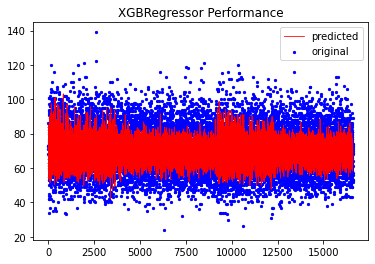


    ----------------------------------------------------------------------------
    Model Name: XGBRegressor
    Train and Assembly Time: 162.052
    Mean Average Error: 8.91
    Mean Squared Error: 126.929
    Mean Absolute Percentage Error: 0.129
    R2: 0.165
    ----------------------------------------------------------------------------
    
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=15, subsample_freq=0 will be ignored. Current value: bagging_freq=15


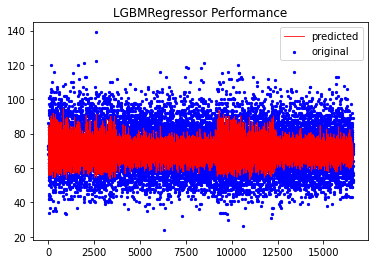


    ----------------------------------------------------------------------------
    Model Name: LGBMRegressor
    Train and Assembly Time: 5.98
    Mean Average Error: 8.751
    Mean Squared Error: 122.04
    Mean Absolute Percentage Error: 0.127
    R2: 0.197
    ----------------------------------------------------------------------------
    


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
..............................[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.6s finished


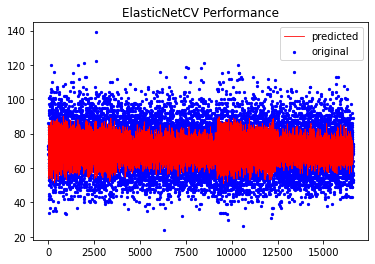


    ----------------------------------------------------------------------------
    Model Name: ElasticNetCV
    Train and Assembly Time: 1.976
    Mean Average Error: 8.758
    Mean Squared Error: 122.172
    Mean Absolute Percentage Error: 0.128
    R2: 0.196
    ----------------------------------------------------------------------------
    


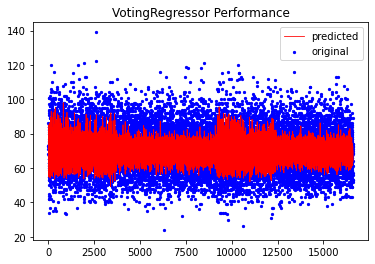


    ----------------------------------------------------------------------------
    Model Name: VotingRegressor
    Train and Assembly Time: 167.735
    Mean Average Error: 8.748
    Mean Squared Error: 122.268
    Mean Absolute Percentage Error: 0.127
    R2: 0.196
    ----------------------------------------------------------------------------
    


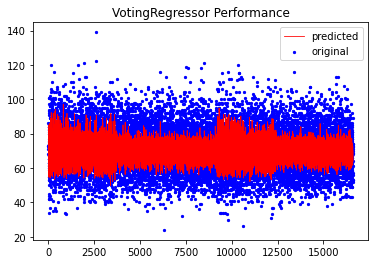


    ----------------------------------------------------------------------------
    Model Name: VotingRegressor
    Train and Assembly Time: 169.363
    Mean Average Error: 8.735
    Mean Squared Error: 121.885
    Mean Absolute Percentage Error: 0.127
    R2: 0.198
    ----------------------------------------------------------------------------
    


In [ ]:
reg_data_results = test_models(algorithms, [train, train_label], [test, test_label])

In [ ]:
# Make a nice, trite results table for the chosen model(s)
res = pd.DataFrame.from_dict(reg_data_results).T.sort_values(by='Mean Absolute Percentage Error', ascending=True)

In [ ]:
# Get SHAP values for each of the 3 base models
elasticnet_explainer = shap.LinearExplainer(elasticnet_model, train)
elasticnet_shap_vals = elasticnet_explainer.shap_values(test[:150])

xgb_explainer = shap.TreeExplainer(xgboost_model)
xgb_shap_vals = xgb_explainer.shap_values(test[:150])

lgbm_explainer = shap.TreeExplainer(lgbm_model)
lgbm_shap_vals = lgbm_explainer.shap_values(test[:150])

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


In [ ]:
# Transform SHAP data
lgbm_shap_df = pd.DataFrame(pd.DataFrame(data=lgbm_shap_vals, columns=test.columns).abs().mean()).T
lgbm_shap_df['Algorithm'] = 'LightGBM'

xgb_shap_df = pd.DataFrame(pd.DataFrame(data=xgb_shap_vals, columns=test.columns).abs().mean()).T
xgb_shap_df['Algorithm'] = 'XGBoost'

elasticnet_shap_df = pd.DataFrame(pd.DataFrame(data=elasticnet_shap_vals, columns=test.columns).abs().mean()).T
elasticnet_shap_df['Algorithm'] = 'ElasticNet'

shap_df = pd.concat([lgbm_shap_df, xgb_shap_df, elasticnet_shap_df])

## TODO: Provide breakdown of top 10 most important features (on average) by algorithm

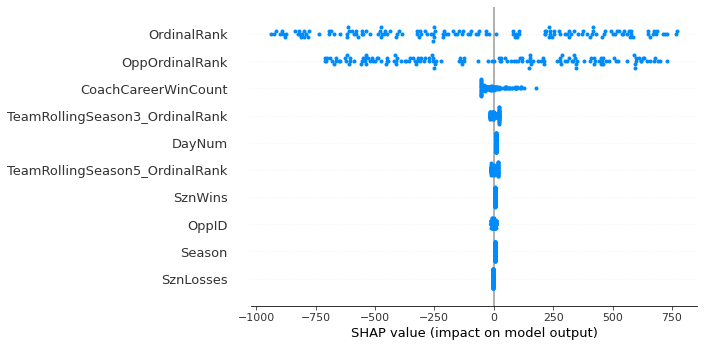

In [ ]:
# Visualize SHAP for elasticnet
shap.summary_plot(elasticnet_shap_vals, features=train.columns, max_display=10, title="ElasticNet SHAP Values")

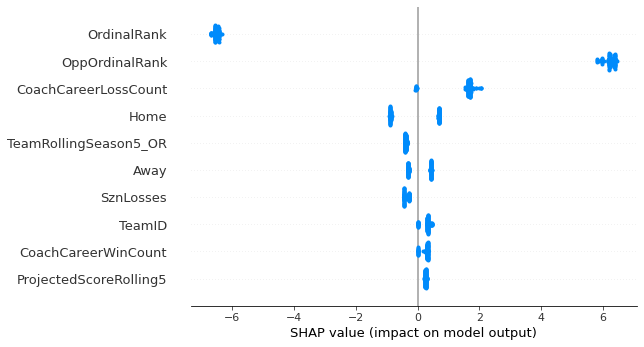

In [ ]:
# Visualize SHAP for LightGBM
shap.summary_plot(lgbm_shap_vals, features=train.columns, max_display=10, title="LightGBM SHAP Values")

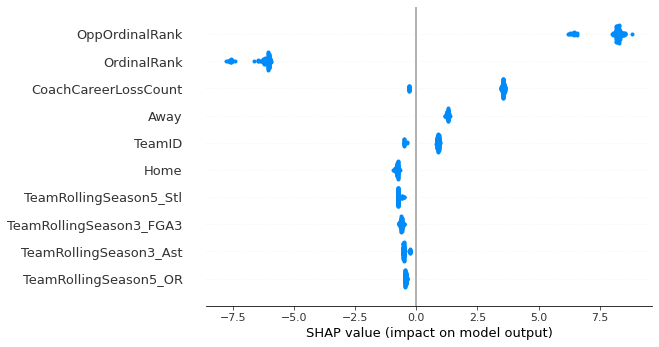

In [ ]:
# Visualize SHAP for XGBoost
shap.summary_plot(xgb_shap_vals, features=train.columns, max_display=10, title="XGBoost SHAP Values")

In [ ]:
# Get 3D clustered data and plot it with error color bars
umap_obj = umap.UMAP(n_neighbors=30, n_components=3, random_state=42)
ss = StandardScaler()
plot_df = pd.DataFrame(data=umap_obj.fit_transform(ss.fit_transform(test)), columns=['UMAP-1', 'UMAP-2','UMAP-3'])
plot_df['ActualScore'] = test_label.values
plot_df['PredScore'] = voting_model.predict(test)
# Get % error
plot_df['Error'] = (abs(plot_df['ActualScore'] - plot_df['PredScore'])/plot_df['ActualScore'])*100

In [ ]:
# Plot the clustered data with error margins
fig = px.scatter_3d(plot_df, x='UMAP-1', y='UMAP-2', z='UMAP-3', color='Error', color_continuous_scale = px.colors.sequential.Reds, range_color=(0,50), title="Training Data Clustered")
fig.show(renderer='colab')